In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config import CONFIG
from prototype_utils import plot_point_cloud_and_bboxes,  bboxes_df_to_numpy_corners, filter_roi

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
home = os.path.join(os.path.expanduser('~'), CONFIG['HOME_PATH'][CONFIG['OS']])

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

INFO - 2025-01-18 19:18:43,553 - synchronization_database - Building SynchronizationDB


In [278]:
scene_idx = 9
frame_idx = 100

ps_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['ROI'])

scene_id_ps = os.listdir(ps_path)[scene_idx]
scene_path = os.path.join(ps_path, scene_id_ps)

frame_id_ps = os.listdir(scene_path)[frame_idx]
frame_path_ps = os.path.join(ps_path, scene_id_ps, frame_id_ps)



In [279]:
frame_id_ps.split(".")[0]

'315975243659892000'

In [280]:
# scene_id = av2.get_log_ids()[scene_idx]
# frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id_ps, frame_id_ps.split(".")[0])

points = Sweep.from_feather(frame_path).xyz

In [281]:
# print(f"Dataset scene_id:{scene_id} and frame_id:{frame_id}")

In [282]:
# ps_path = os.path.join(home, *CONFIG['BBOX_FILE_PATHS']['ROI'])

# scene_id_ps = os.listdir(ps_path)[scene_idx]
# scene_path = os.path.join(ps_path, scene_id_ps)

# frame_id_ps = os.listdir(scene_path)[frame_idx]
# frame_path_ps = os.path.join(ps_path, scene_id_ps, frame_id_ps)

In [283]:
print(f"Loaded scene_id:{scene_id_ps} and frame_id:{frame_id_ps}")

Loaded scene_id:b8d83d8e-1574-3efd-b067-a3ed422a259e and frame_id:315975243659892000.feather


In [284]:
bboxes_df = pd.read_feather(frame_path_ps)
bboxes_df.head()

,box_center_x,box_center_y,box_length,box_width,ry
0,23.089365,-13.748349,18.258527,14.719659,1.047198
1,4.374023,-12.914062,4.171875,2.001953,1.570796
2,1.871179,-4.369143,1.082472,0.621808,1.483530
3,0.799139,-13.316406,13.304688,1.597034,1.570796
4,20.113796,17.468205,1.799440,1.696985,0.349066


In [285]:
bboxes_np = bboxes_df_to_numpy_corners(bboxes_df)

In [286]:
points_roi = filter_roi(points)

In [287]:
bboxes_df['aspect_ratio'] = bboxes_df['box_width'] / bboxes_df['box_length']
bboxes_df['aspect_ratio']

bboxes_df['area'] = bboxes_df['box_width'] * bboxes_df['box_length']

In [288]:
bboxes_df.head()

,box_center_x,box_center_y,box_length,box_width,ry,aspect_ratio,area
0,23.089365,-13.748349,18.258527,14.719659,1.047198,0.806180,268.759297
1,4.374023,-12.914062,4.171875,2.001953,1.570796,0.479869,8.351898
2,1.871179,-4.369143,1.082472,0.621808,1.483530,0.574433,0.673090
3,0.799139,-13.316406,13.304688,1.597034,1.570796,0.120035,21.248032
4,20.113796,17.468205,1.799440,1.696985,0.349066,0.943063,3.053622


array([[<Axes: title={'center': 'aspect_ratio'}>]], dtype=object)

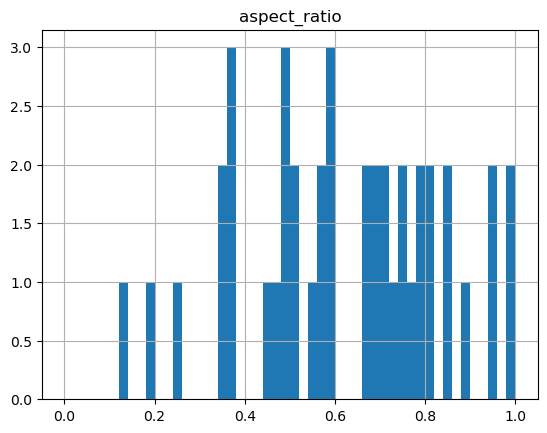

In [289]:
bboxes_df.hist(column='aspect_ratio', bins=50, range=(0, 1))

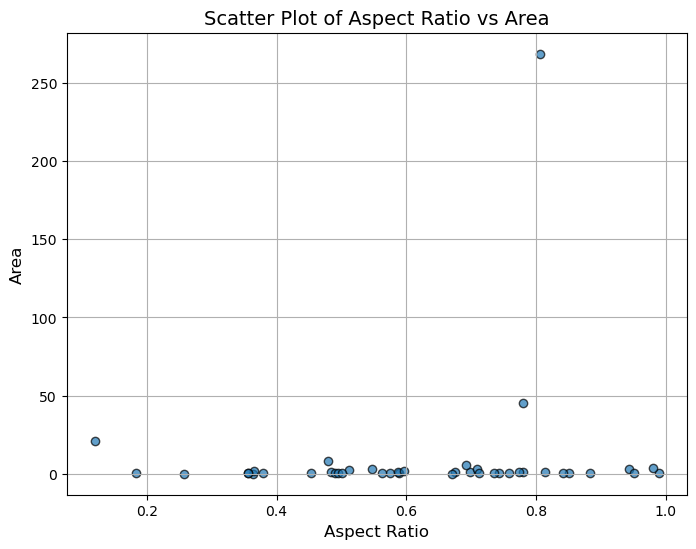

In [290]:
def plot_aspect_ratio_vs_area(df, aspect_ratio_col, area_col, title="Scatter Plot of Aspect Ratio vs Area"):
    """
    Plots a scatter plot of aspect ratio vs area.

    Args:
        df (pd.DataFrame): The DataFrame containing aspect ratio and area.
        aspect_ratio_col (str): The column name for aspect ratios in the DataFrame.
        area_col (str): The column name for areas in the DataFrame.
        title (str): The title of the scatter plot.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(df[aspect_ratio_col], df[area_col], alpha=0.7, edgecolor='k')
    plt.title(title, fontsize=14)
    plt.xlabel('Aspect Ratio', fontsize=12)
    plt.ylabel('Area', fontsize=12)
    plt.grid(True)
    plt.show()

# Example usage:
plot_aspect_ratio_vs_area(bboxes_df, 'aspect_ratio', 'area')


In [291]:
from stats_filter2 import apply_rect_filter, apply_large_sq_filter

config_rect_filter = CONFIG['RECT_FILTER_THRESHOLDS']['ROI']['IOU_THRESHOLD_0.3']
config_sq_filter = CONFIG['SQUARE_FILTER_THRESHOLDS']['ROI']['IOU_THRESHOLD_0.3']

rect_filter_max_ratio = config_rect_filter['MAX_RATIO']
rect_filter_max_area = config_rect_filter['MAX_AREA']

sq_filter_min_ratio = config_sq_filter['MIN_RATIO']
sq_filter_min_area = config_sq_filter['MIN_AREA']

_, rect_filter_df = apply_rect_filter(bboxes_df, 'aspect_ratio', 'area',rect_filter_max_ratio,rect_filter_max_area )

_ , square_filter_df = apply_large_sq_filter(bboxes_df, 'aspect_ratio', 'area', sq_filter_min_ratio, sq_filter_min_area)

_ , combined_df = apply_large_sq_filter(rect_filter_df, 'aspect_ratio', 'area', sq_filter_min_ratio, sq_filter_min_area)

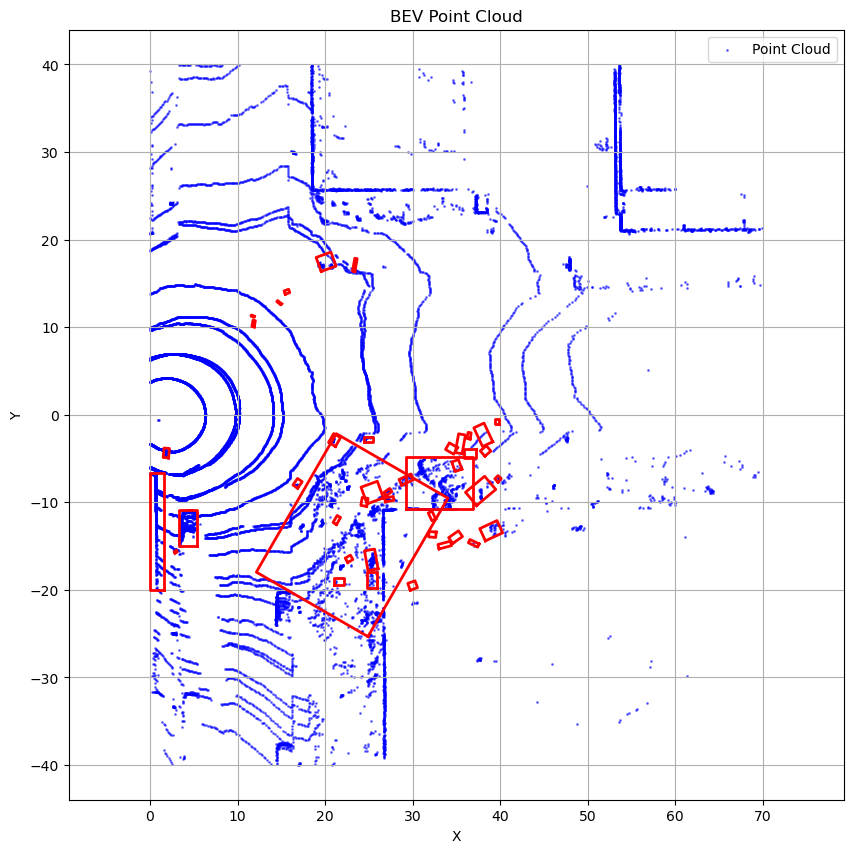

In [292]:
plot_point_cloud_and_bboxes(points_roi[:,:2], bboxes_np, title="BEV Point Cloud")

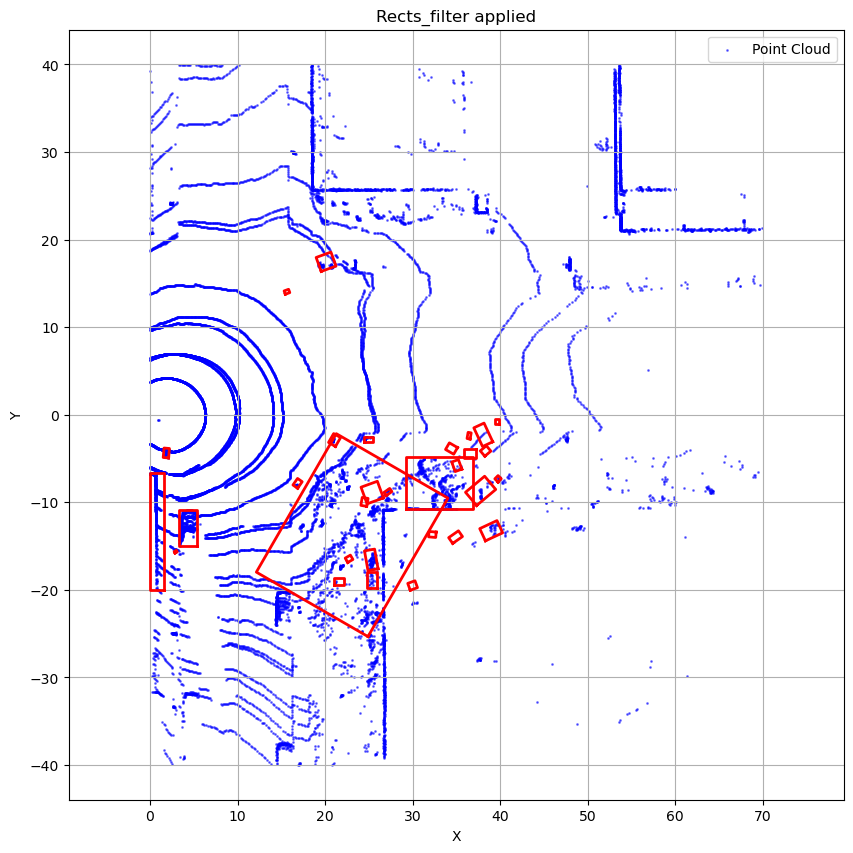

In [293]:
plot_point_cloud_and_bboxes(points_roi[:,:2],
                            bboxes_df_to_numpy_corners(rect_filter_df),
                            title="Rects_filter applied")

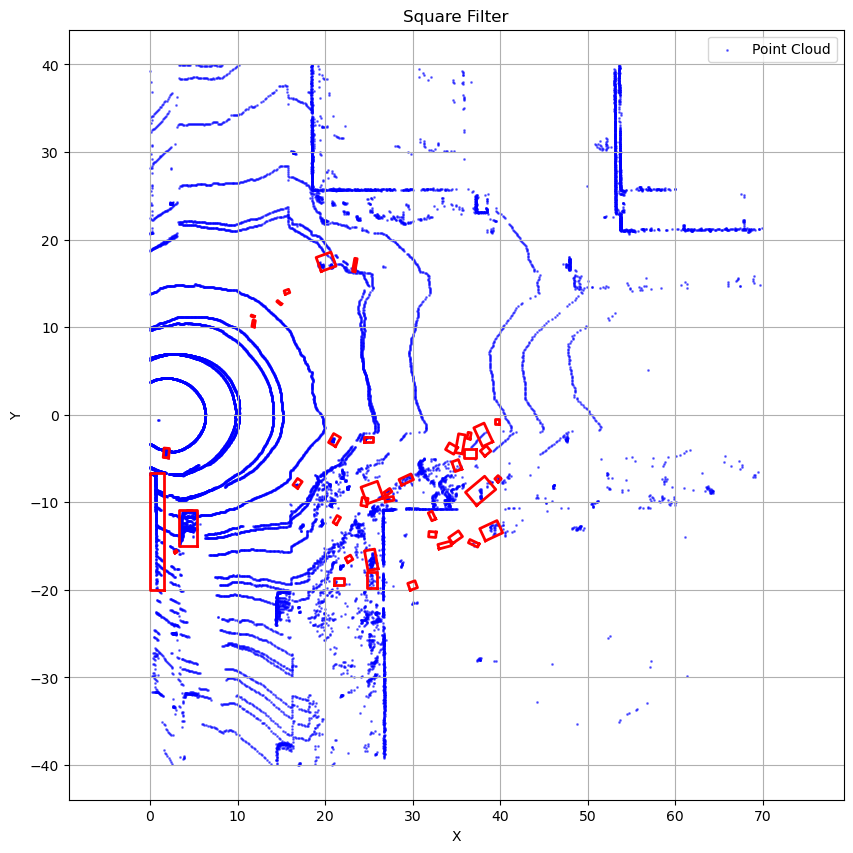

In [294]:
plot_point_cloud_and_bboxes(points_roi[:,:2],
                            bboxes_df_to_numpy_corners(square_filter_df),
                            title="Square Filter")

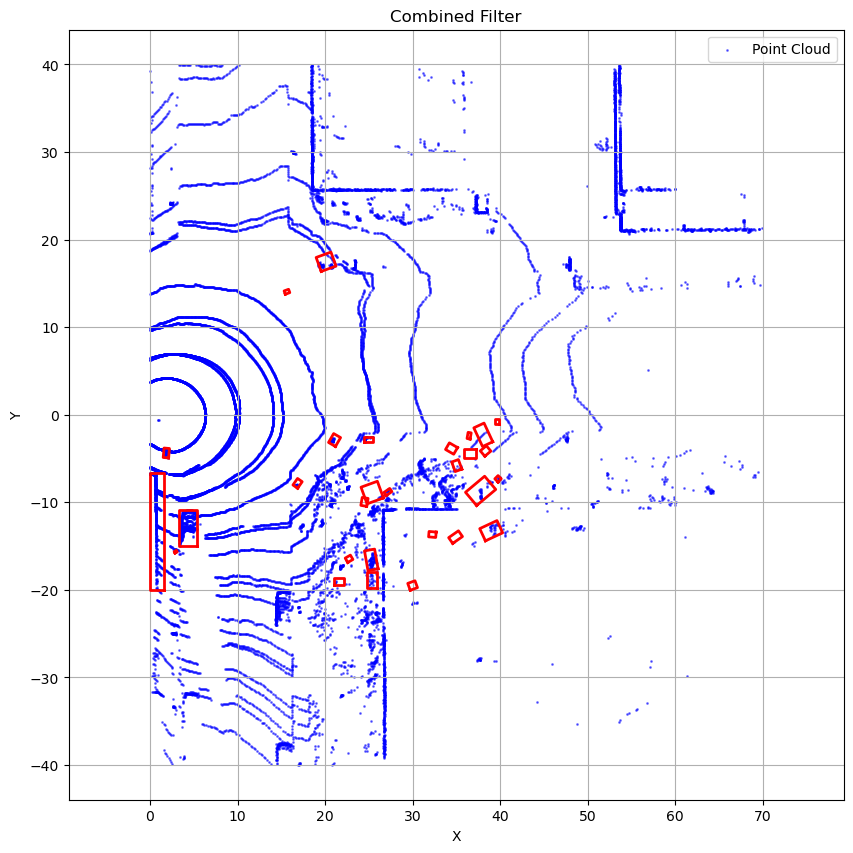

In [295]:
plot_point_cloud_and_bboxes(points_roi[:,:2],
                            bboxes_df_to_numpy_corners(combined_df),
                            title="Combined Filter")